### Protein Composition Statistics

The analysis functions are located in `./indels/proteins.py`, which draws general functions from `./indels/ind.py`

In [1]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import pprint

from string import ascii_lowercase
from collections import Counter, defaultdict, OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.Emboss.Applications import NeedleallCommandline

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

In [3]:
os.chdir("/mnt/c/Users/Maya/Dropbox/mek_results")

with open('Remkes_protein.p', 'rb') as f:
    all_ref = pickle.load(f)
with open('Remkes_protein_low.p', 'rb') as f:
    low = pickle.load(f)

all_ref['mek']['low-v2'] = low['mek']['low-v2']

mek = {}
for fraction in ['high', 'med']:
    mek[fraction] = Counter(all_ref['mek'][fraction])
mek['low-t'] = Counter(all_ref['mek']['low']) + Counter(all_ref['mek']['low-v2'])

df_all = pd.DataFrame.from_dict(mek).fillna(0).sort_values(by=['high', 'med', 'low-t'], ascending=False)

### How many variants are there?

In [47]:
cutoff = 10
vars_by_count = OrderedDict((i, 0) for i in range(1, cutoff +1))
for c in mek['high'].values():
    if c >= cutoff:
        vars_by_count[cutoff] +=1
    else:
        vars_by_count[c] +=1
vars_by_count

OrderedDict([(1, 119584),
             (2, 21133),
             (3, 6838),
             (4, 2936),
             (5, 1498),
             (6, 857),
             (7, 579),
             (8, 430),
             (9, 330),
             (10, 36702)])

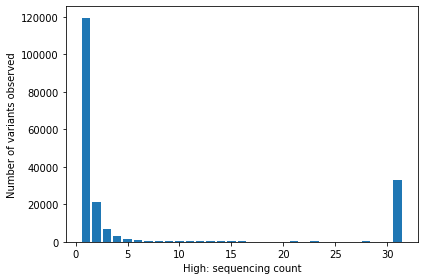

In [33]:
cutoff = 31
vars_by_count = OrderedDict((i, 0) for i in range(1, cutoff +1))
for c in mek['high'].values():
    if c >= cutoff:
        vars_by_count[cutoff] +=1
    else:
        vars_by_count[c] +=1

plt.bar(vars_by_count.keys(), vars_by_count.values())
plt.xlabel('High: sequencing count')
plt.ylabel('Number of variants observed')
plt.tight_layout()
plt.savefig('Seq_cutoffs_high_1.png')
plt.show()

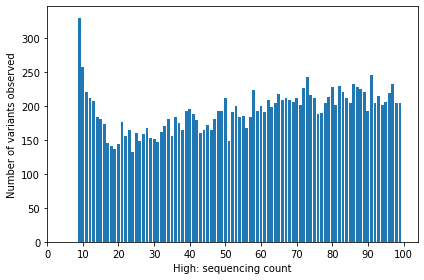

In [9]:
cutoff = 100
vars_by_count = OrderedDict((i, 0) for i in range(1, cutoff +1))
for c in mek['high'].values():
    if c >= cutoff:
        vars_by_count[cutoff] +=1
    else:
        vars_by_count[c] +=1

plt.bar(list(vars_by_count.keys())[8:-1], list(vars_by_count.values())[8:-1])
plt.xticks(np.arange(0, cutoff+1, 10))
plt.xlabel('High: sequencing count')
plt.ylabel('Number of variants observed')
plt.tight_layout()
plt.savefig('Seq_cutoffs_high_2.png')
plt.show()

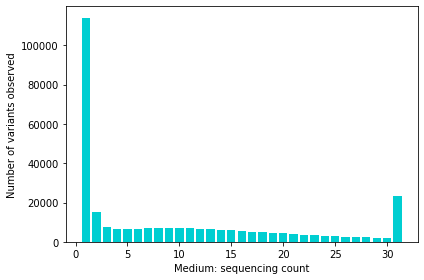

In [21]:
cutoff = 31
vars_by_count = OrderedDict((i, 0) for i in range(1, cutoff +1))
for c in mek['med'].values():
    if c >= cutoff:
        vars_by_count[cutoff] +=1
    else:
        vars_by_count[c] +=1

plt.bar(vars_by_count.keys(), vars_by_count.values(), color='darkturquoise')
plt.xlabel('Medium: sequencing count')
plt.ylabel('Number of variants observed')
plt.tight_layout()
plt.savefig('Seq_cutoffs_med_1.png')
plt.show()

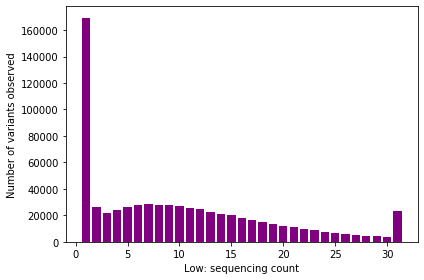

In [22]:
cutoff = 31
vars_by_count = OrderedDict((i, 0) for i in range(1, cutoff +1))
for c in mek['low-t'].values():
    if c >= cutoff:
        vars_by_count[cutoff] +=1
    else:
        vars_by_count[c] +=1

plt.bar(vars_by_count.keys(), vars_by_count.values(), color='purple')
plt.xlabel('Low: sequencing count')
plt.ylabel('Number of variants observed')
plt.tight_layout()
plt.savefig('Seq_cutoffs_low_1.png')
plt.show()

How many times does the WT appear in each bin?

In [8]:
df_all.loc['6P/9I/11L/13P']

high     51.0
med      36.0
low-t    34.0
Name: 6P/9I/11L/13P, dtype: float64

In [131]:
df_all.loc['6P/9A/11A/13P']

high      0.0
med       6.0
low-t    20.0
Name: 6P/9A/11A/13P, dtype: float64

In [11]:
df_all.loc['6P/9I/11L/13P']/df_all.loc['6P/9I/11L/13P'].sum()

high     0.421488
med      0.297521
low-t    0.280992
Name: 6P/9I/11L/13P, dtype: float64

Cutoff criteria for variants to be considered acrive are built based on WT:
- 51 or more reads in high bin
- more reads in high than in low bin
- more reads in high than in medium bin
- 42% or more reads total in high bin

In [12]:
df_51 = df_all.loc[(df_all['high'] >= 51)]

In [13]:
df_51.describe()

,high,med,low-t
count,29603.000000,29603.000000,29603.000000
mean,146.213931,11.612810,11.432895
std,87.679320,15.697705,10.396649
min,51.000000,0.000000,0.000000
25%,87.000000,0.000000,5.000000
50%,123.000000,3.000000,10.000000
75%,177.000000,19.000000,16.000000
max,1185.000000,232.000000,453.000000


In [92]:
df_pos = df_all.loc[(df_all['high'] >= 51) & (df_all['high'] > df_all['low-t']) & (df_all['high'] > df_all['med']) &
                   (df_all['high'] > 0.42*(df_all['high'] + df_all['med'] + df_all['low-t']))]
# this filtering removed 35 variants based on H>L, H>M condition and 4 based on %H. Leaves one variants with a stop codon.

In [93]:
df_pos[df_pos.index.str.contains('*', regex=False)]

,high,med,low-t
6L/7aI/9A/9a*,53.0,24.0,23.0


In [94]:
df_pos = df_pos.drop(['6L/7aI/9A/9a*'])

In [43]:
df_pos.describe()

,high,med,low-t
count,29563.000000,29563.000000,29563.000000
mean,146.294524,11.512363,11.300274
std,87.695445,15.393163,8.303405
min,51.000000,0.000000,0.000000
25%,87.000000,0.000000,5.000000
50%,123.000000,3.000000,10.000000
75%,177.000000,19.000000,16.000000
max,1185.000000,136.000000,80.000000


We now have a total of 29,563 variants in the active dataset.

## Counting single, double, triple mutants

In [77]:
# Set general restrictions stemming from SpliMLib library design
aa_2 = ['A', 'Δ']
aa_12 = ['A','G','P','Y','D','K','M','V','I','L','F','W']
aa_13 = aa_12 +  ['Δ']
pos_aa = {'6': aa_12, '9': aa_12, '11': aa_12, '13': aa_12, '7a': aa_13, '8a': aa_2}

# hamming distance = 0 if the aa matches at all positions
def hamming_distance(s1, s2, pos_aa):
    d = 0
    
    if len(s1.keys()) != len(s2.keys()):
        print('Variant lenghts unequal')
        raise
        
    for p in pos_aa.keys():
        if s1[p] != s2[p]:
            d += 1
    return d

def convert_variant_to_dict(mutation_string):
    """
    Convert a string of positions deviating from WT into a dictionary listing the status at all positions
    Input: string of the format '6A/7aK/9L' etc.
    Output: dictionary listing AA at each position, including WT
    """
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}
    
    mutation_list = mutation_string.split('/')
    m_by_pos = {point_mutation[:-1] : point_mutation[-1] for point_mutation in mutation_list}
    
    for position in wt.keys():   # need to do it this way so that WT positions are included
        try:
            m_by_pos[position]
        except KeyError:
            m_by_pos[position] = wt[position]

    return m_by_pos

In [47]:
wt_short = '6P/9I/11L/13P'
wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}

positive_vars = df_pos.index.tolist()

In [78]:
h_dist = {}
for v in positive_vars:
    s1 = convert_variant_to_dict(v)
    h_dist[v] = hamming_distance(wt, s1, pos_aa)

In [95]:
df_pos['wt_hamming']= df_pos.index.map(h_dist)
df_pos.describe()

,high,med,low-t,wt_hamming
count,29563.000000,29563.000000,29563.000000,29563.000000
mean,146.294524,11.512363,11.300274,4.821635
std,87.695445,15.393163,8.303405,0.884174
min,51.000000,0.000000,0.000000,0.000000
25%,87.000000,0.000000,5.000000,4.000000
50%,123.000000,3.000000,10.000000,5.000000
75%,177.000000,19.000000,16.000000,5.000000
max,1185.000000,136.000000,80.000000,6.000000


In [99]:
df_pos['wt_hamming'].value_counts().sort_index()

0        1
1       13
2      214
3     1862
4     7647
5    13029
6     6797
Name: wt_hamming, dtype: int64

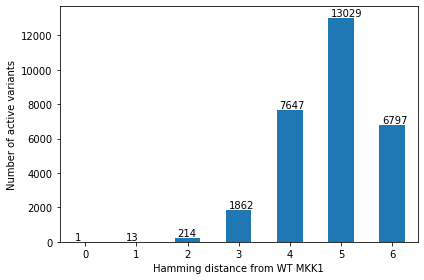

In [126]:
ax = df_pos['wt_hamming'].value_counts().sort_index().plot.bar(rot=0)

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + 0.05, p.get_height()+100))

plt.xlabel('Hamming distance from WT MKK1')
plt.ylabel('Number of active variants')
plt.tight_layout()
plt.savefig('Hamming_distance_distribution.png')
plt.show()

### Single mutants

In [130]:
df_pos[df_pos['wt_hamming'] == 1]

,high,med,low-t,wt_hamming
6P/9I/11F/13P,263.0,15.0,3.0,1
6P/9I/11L/13I,230.0,12.0,16.0,1
6P/9I/11L/13L,173.0,37.0,3.0,1
6P/7aL/9I/11L/13P,148.0,3.0,14.0,1
6P/9P/11L/13P,136.0,1.0,16.0,1
6P/9F/11L/13P,118.0,13.0,3.0,1
6P/7aK/9I/11L/13P,108.0,15.0,7.0,1
6P/9I/11L/13W,108.0,1.0,15.0,1
6P/9I/11M/13P,102.0,46.0,8.0,1
6I/9I/11L/13P,83.0,0.0,14.0,1
